# Use Uber movement data to conduct speed prediction for each given street

The data is downloaded from Uber movement website. Here, we only use data from Feb 2020 for Seattle area (GPS coordinates of the data area: -122.447676, 47.510547, -122.265260, 47.734649"). 

This data have been procseed, and merged with some other data source. The data we use is save in hist_adj_select_weather.csv'.

In [8]:
import csv, time, pickle
import pandas as pd
import json
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sklearn

### Data loading and preparation
The data here is more than the orginal data that we downloaded from uber movement data. For this project, we only use the data from Feb, 2020.
- There are features from orginial Uber movement data or slightly derived from original data, such as 'hour', 'weekday', 'rush_hour', 'osmhighway'.
- There are features that we use osmwayid and GeoJson data to derive, mainly use the GPS coordinates of the street's start node and end node to derive 'direction' of a street, 'max_speed'.
- There are features about the weather information, that we downloaded from https://www.wunderground.com/. 

In [4]:
# READ all the parameters from the prepared data file 
filename  = 'hist_adj_select_weather.csv' # the output file name in the folder.                          
df = pd.read_csv(filename )               # read the data in as pandas data frame
parameters_value  = df.values             # all the parameter values
parameters_name   = df.keys()   
print("Total number of " + str(len(df)) + " observations")
print(parameters_name)

Total number of 3481341 observations
Index(['Unnamed: 0', 'weekend_or_weekday', 'hour', 'weekday', 'rush_hour',
       'osmhighway', 'osmhighway_adj', 'max_speed', 'day', 'speed_mph_mean',
       'speed_mph_qtr_mean', 'speed_mph_qtr_std', 'speed_diff', 'osmdistance',
       'direction', 'osmstartnodelon', 'osmstartnodelat', 'osmendnodelon',
       'osmendnodelat', 'station', 'Temperature', 'Wind', 'Rain',
       'osmhighway_num', 'direction_num'],
      dtype='object')


### Use features that are useful to build the model
We have conduct numerous experiemnts to understand the impact of the data. We have concluded that there are many features that is not useful for conduct speed or speed difference prediction. We are not showing the work here. 

Below are some features that down selected for our final project. There are 4 features that are important to condcut the prediction: 'hour', 'speed_mph_qtr_std', 'weekday', 'max_speed'.

'day' feature we leave it here, because we will later split the data based on the day of the month. We use the first 3 weeks of Feb data as training data, and the last week of Feb data as testing data. 

In the case of predict speed difference (the difference between the estimated speed and quarterly mean), 'speed_mph_qtr_mean' (quarterly aggregated average speed for a particular hour) will be used to back calculate the current estimated speed when obtain a predicted speed difference. At this time 'speed_diff' will be our y in prediction. 

In the case of predict the speed directly, 'speed_mph_mean' is the mean. 

In [5]:

# only select the top 4 features for training. 
# the first row here is the top 4 features,
# the second row here is variables that will be needed to split data and 
# back calculate the speed after speed_diff prediction
features = df[[ 'hour',  'speed_mph_qtr_std',  'weekday', 'max_speed',\
                 'day', 'speed_mph_qtr_mean',  'speed_mph_mean' ,\
                 'speed_diff']]

### Here we show how to use the features to conduct speed difference prediction
We will split the data based on the day of the Feb 2020. 
Roughly, we use the first three weeks as training data, and the last week as the testing data. 

In [6]:
# split data into training and testing sets

# Split the data into training and testing sets
# train_features, test_features, train_labels, test_labels = train_test_split(features2, labels, test_size = 0.25, 
#                                                                             random_state = 42)
# !!! predict the speed difference from quaterly agg data.
# !!! after predict, we can use the predict diff to add back to the quaterly agg data. 
# !!! use the last week for test, previous data used as training data

is_train =  features['day']< 22
train = features[is_train]
is_test = features['day']>= 22
test = features[is_test]

# feature

train_features = train.drop(["speed_diff","day", 'speed_mph_mean','speed_mph_qtr_mean'], axis = 1)  
test_features = test.drop(["speed_diff","day", 'speed_mph_mean', 'speed_mph_qtr_mean'], axis = 1)    
   

feature_list = list(train_features.columns)  # list of strings

train_features = np.array(train_features)
test_features = np.array(test_features)


# labels
train_labels = train[["speed_diff"]]
test_labels = test[["speed_diff"]]
# quarterly speed mean is not used to conduct speed diff prediction,
# but used to calculate the final estimate speed outcome
test_qart_speed = test[['speed_mph_qtr_mean']]  # quaterly speed
test_mean_speed = test[['speed_mph_mean']]      # mean speed of this road a day

train_labels = np.array(train_labels)[:,0]
test_labels = np.array(test_labels)[:,0]

test_qart_speed = np.array(test_qart_speed)[:,0]
test_mean_speed = np.array(test_mean_speed)[:,0]

print('Training Features Shape:',       train_features.shape)
print('Training Labels Shape:',         train_labels.shape)
print('Testing Features Shape:',        test_features.shape)
print('Testing Labels Shape:',          test_labels.shape)

print('Testing quarterly speed Shape:', test_qart_speed.shape)

Training Features Shape: (2592181, 4)
Training Labels Shape: (2592181,)
Testing Features Shape: (889160, 4)
Testing Labels Shape: (889160,)
Testing quarterly speed Shape: (889160,)


### Train a random forest regressor based model
Here, we will use number of trees 20, and depth as 18 to train the mode. We have conduct the hyperparameter tunning experiment to show that the performance of the model will not be improved after number of trees is 100. The fact that when number of trees is 20, the performance is already close to what is when the nubmer of trees is 100. We are not showing the hyperparameter tunning experiment results here. 

But just use the parameter number of trees 100, and depth 18 to show how to conduct the training. 

In [11]:
#%%  Train the model 
my_num = 100; my_depth =  18;

model = RandomForestRegressor(n_estimators = my_num, random_state = 42, 
                              max_depth=my_depth, n_jobs = -1,
                              oob_score = True,  
                              max_features='sqrt', 
                              min_samples_leaf = 25,
                              verbose = 1,  
                              bootstrap=True, 
                              max_samples  = 0.8) 
model.fit(train_features, train_labels); # Train the model on training data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


### back calculate the speed
We will add the predcited speed difference onto the quarterly mean, to estimated what is the current predicted speed for this street. 

We use Mean Absolute Percentage Error (MAPE) to quantify how well our model performs. 

In [13]:

# Predict my speed diff, add speed diff back to the quarterly mean
predictions_diff = model.predict(test_features)
predictions      = predictions_diff + test_qart_speed # add predict diff back to speed mean
test_outcome     = test_mean_speed   
predictions_diff_speed = predictions

# Calculate the absolute errors between the estimated predicted speed and reald mean speed in test data
errors = abs(predictions - test_outcome) 
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# calculate accuracy
mape = 100 * (errors / test_outcome) # Calculate mean absolute percentage error (MAPE)
accuracy0 = 100 - np.mean(mape)      # Calculate and display accuracy
print('MAPE Accuracy:', round(accuracy0, 2), '%.')


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s


Mean Absolute Error: 2.01 degrees.
MAPE Accuracy: 89.66 %.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


### Visualize the predicted results
Plot the first 1000 observations to see. 

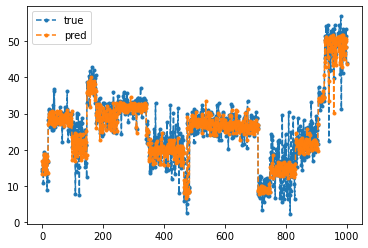

In [15]:
#%%
test_labels_speed = test_labels + test_qart_speed # for test data, add the speed diff back to the quaterly mean

plt.figure()
plt.plot(test_labels_speed[0:1000], '--.')
plt.plot(predictions[0:1000], '--.')
plt.legend(['true','pred'])


### Look at the importance of our training features

Variable: hour                 Importance: 0.29
Variable: weekday              Importance: 0.28
Variable: speed_mph_qtr_std    Importance: 0.27
Variable: max_speed            Importance: 0.17


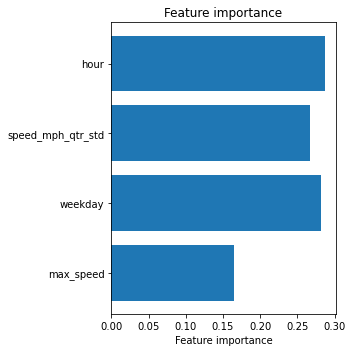

In [16]:

# variable importance
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


plt.rcParams.update({'figure.autolayout': True})

#plt.rcdefaults()
fig, ax = plt.subplots(figsize=(5,5))

# Example data
#people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
y_pos = np.arange(len(feature_list))
#performance = 3 + 10 * np.random.rand(len(feature_list))
error = np.random.rand(len(feature_list))

ax.barh(y_pos, importances, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_list)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importance')
ax.set_title('Feature importance')

plt.show()